# 模組 3.3: 異常值偵測方法 (Outlier Detection)

## 學習目標
- 理解異常值的定義及其對統計分析和機器學習模型的潛在影響。
- 學習使用視覺化方法（如箱型圖、散點圖）來直觀地識別異常值。
- 掌握基於統計規則的異常值偵測方法，特別是 IQR 法則和 Z-score。
- 能夠為不同特徵選擇合適的偵測技術。

## 導論：什麼是異常值？

在您的指南中提到：「*防止異常值扭曲統計量（如均值）、干擾模型訓練（尤其是線性模型、基於距離的演算法），或違反模型假設*」。

**異常值 (Outlier)** 是指在資料集中與其他觀測值顯著不同的數據點。它們可能是由於測量或輸入錯誤造成的，也可能是真實但極端的觀測結果。無論成因如何，異常值都會對分析產生不成比例的影響，因此在建模前識別它們至關重要。本筆記本將介紹幾種最常用、最基礎的偵測方法。

In [7]:
# 導入必要的函式庫
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer

# 設定視覺化風格
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False
print("Libraries and styles configured.")

# 忽略不必要的警告訊息
import warnings
warnings.filterwarnings('ignore')




Libraries and styles configured.


## 1. 準備資料

我們繼續使用 House Prices 資料集，這個資料集的 `SalePrice` 和其他特徵中都可能包含異常值。

In [8]:
# 載入資料
path = r'..\..\..\..\datasets\raw\house_prices\train.csv'
try:
    df = pd.read_csv(path)
    print("成功載入 House Prices 資料集!")
except FileNotFoundError:
    print(f"在 '{path}' 找不到 train.csv。")
    df = pd.DataFrame() # 建立空 DataFrame 以免後續出錯


成功載入 House Prices 資料集!


## 2. 視覺化偵測

我們的眼睛是強大的模式識別工具。在進行任何計算之前，先透過視覺化來觀察是個好習慣。

### 2.1 箱型圖 (Box Plot)

箱型圖是偵測單變數異常值的絕佳工具。它明確地將超出 `Q1 - 1.5*IQR` 或 `Q3 + 1.5*IQR` 範圍的點標示為異常值。

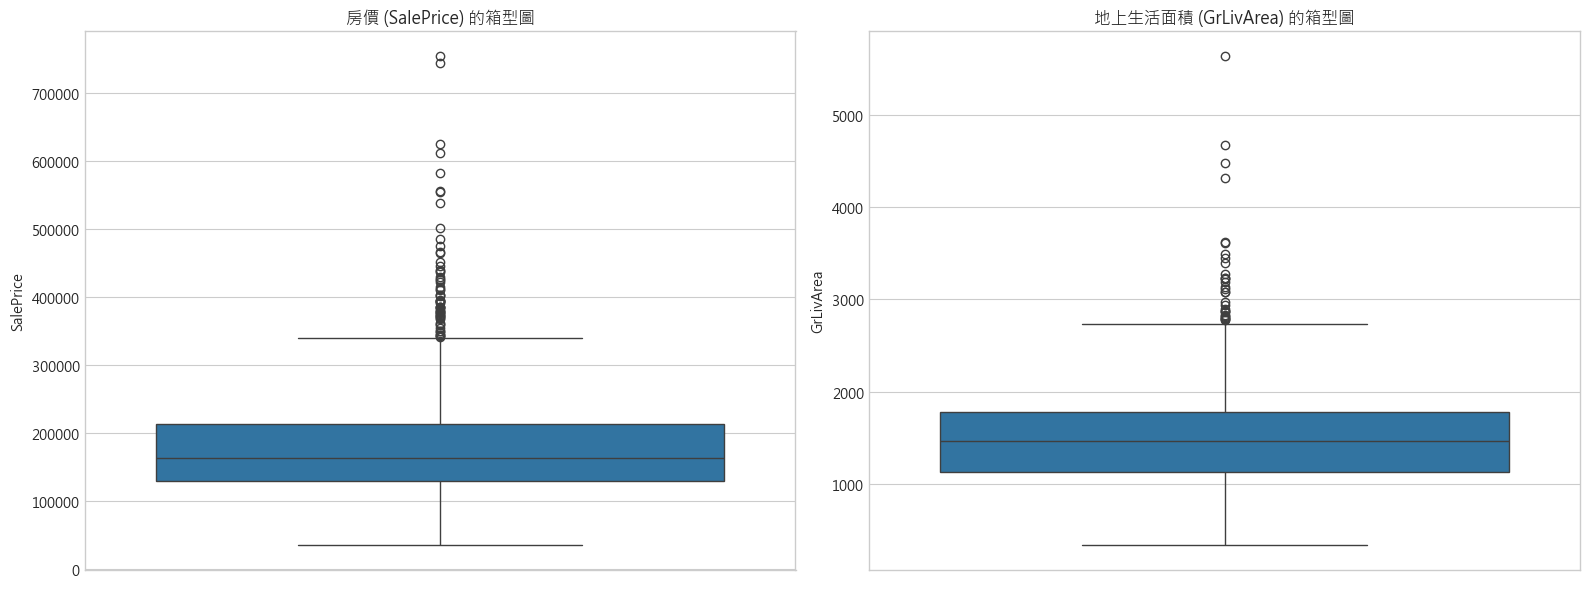

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 查看 'SalePrice' 的異常值
sns.boxplot(y=df['SalePrice'], ax=axes[0])
axes[0].set_title('房價 (SalePrice) 的箱型圖')

# 查看 'GrLivArea' (地上生活面積) 的異常值
sns.boxplot(y=df['GrLivArea'], ax=axes[1])
axes[1].set_title('地上生活面積 (GrLivArea) 的箱型圖')

plt.tight_layout()
plt.show()



**觀察**:
- `SalePrice` 和 `GrLivArea` 都顯示出大量的上邊緣異常值（即數值非常大的點）。

### 2.2 散點圖 (Scatter Plot)

散點圖有助於發現兩個變數關係中的異常點。

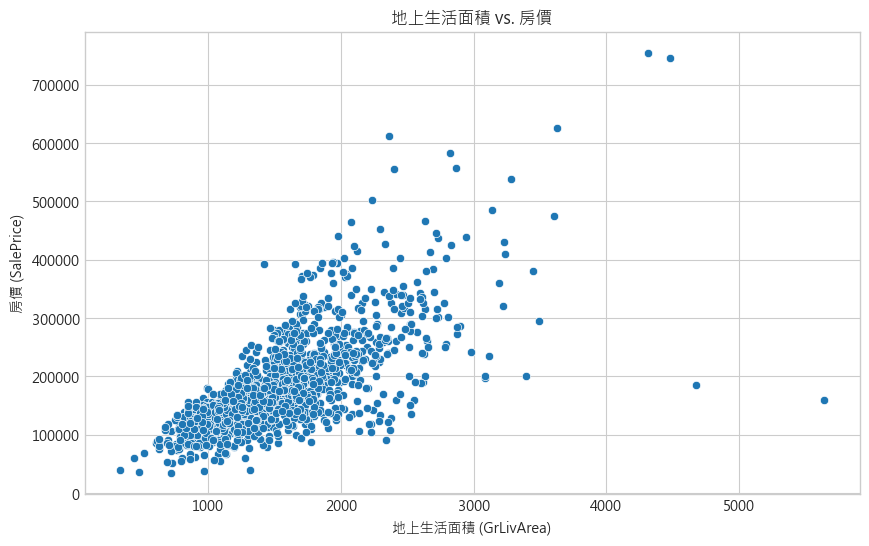

In [10]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['GrLivArea'], y=df['SalePrice'])
plt.title('地上生活面積 vs. 房價')
plt.xlabel('地上生活面積 (GrLivArea)')
plt.ylabel('房價 (SalePrice)')
plt.show()



**觀察**:
- 大部分數據點都集中在左下角，呈現出正相關趨勢。
- 右下角有兩個非常特別的點：它們的生活面積 (`GrLivArea`) 非常大，但房價 (`SalePrice`) 卻異常地低。這種類型的異常值對線性模型（如線性迴歸）的擬合線有極大的干擾作用，強烈建議在建模前將其移除。

## 3. 基於統計規則的偵測

### 3.1 四分位距法 (IQR Rule)

這是與箱型圖背後原理相同的方法。一個數據點如果小於 `Q1 - 1.5 * IQR` 或大於 `Q3 + 1.5 * IQR`，就被視為異常值。

- **Q1**: 第一四分位數 (25th percentile)
- **Q3**: 第三四分位數 (75th percentile)
- **IQR**: 四分位距 (Interquartile Range) = Q3 - Q1

In [11]:
# 以 'SalePrice' 為例，計算 IQR 邊界
Q1 = df['SalePrice'].quantile(0.25)
Q3 = df['SalePrice'].quantile(0.75)
IQR = Q3 - Q1

# 定義異常值邊界
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"房價 (SalePrice) 的 IQR 異常值邊界:")
print(f"下界: {lower_bound:.2f}")
print(f"上界: {upper_bound:.2f}")



房價 (SalePrice) 的 IQR 異常值邊界:
下界: 3937.50
上界: 340037.50


In [12]:
# 找出所有超出邊界的異常值
outliers_iqr = df[(df['SalePrice'] < lower_bound) | (df['SalePrice'] > upper_bound)]
print(f"\n使用 IQR 法則找到 {len(outliers_iqr)} 個異常值。")
display(outliers_iqr[['SalePrice', 'GrLivArea', 'OverallQual']].head())




使用 IQR 法則找到 61 個異常值。


,SalePrice,GrLivArea,OverallQual
11,345000,2324,9
53,385000,1842,9
58,438780,2945,10
112,383970,2696,7
151,372402,1710,8


**優點**: 對數據分佈沒有要求，對偏態數據穩健。
**缺點**: 1.5 這個倍數是經驗法則，不一定適用於所有情況。

### 3.2 Z-Score 法

Z-score 衡量的是一個數據點與平均值之間相差多少個標準差。通常，我們會將 Z-score 的絕對值大於 3 的點視為異常值。

**公式**: Z = (x - μ) / σ
- **x**: 數據點
- **μ**: 平均值
- **σ**: 標準差

**注意**: Z-score 法假設數據大致服從常態分佈。對於偏態數據，效果不佳。

In [13]:
# 以 'LotArea' (地塊面積) 為例，它可能更接近常態分佈
# 我們先對其進行對數轉換以使其更對稱
df['LotArea_log'] = np.log1p(df['LotArea'])

# 計算 Z-score
df['LotArea_log_zscore'] = (df['LotArea_log'] - df['LotArea_log'].mean()) / df['LotArea_log'].std()

# 設定閾值為 3
threshold = 3
outliers_zscore = df[np.abs(df['LotArea_log_zscore']) > threshold]

print(f"使用 Z-score 法在對數轉換後的 LotArea 中找到 {len(outliers_zscore)} 個異常值。")
display(outliers_zscore[['LotArea', 'LotArea_log_zscore', 'SalePrice']].head())



使用 Z-score 法在對數轉換後的 LotArea 中找到 33 個異常值。


,LotArea,LotArea_log_zscore,SalePrice
53,50271,3.313374,385000
75,1596,-3.353669,91000
225,1680,-3.254586,112000
227,1869,-3.048641,106000
232,1680,-3.254586,94500


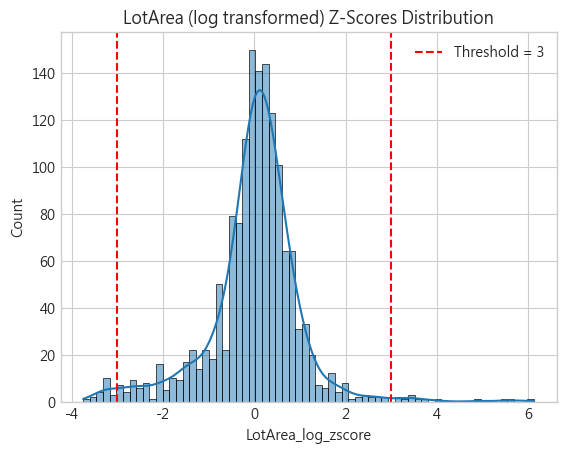

In [14]:
# 視覺化 Z-score
sns.histplot(df['LotArea_log_zscore'], kde=True)
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
plt.axvline(-threshold, color='red', linestyle='--')
plt.title('LotArea (log transformed) Z-Scores Distribution')
plt.legend()
plt.show()




## 總結

在這個筆記本中，我們學習了偵測異常值的幾種核心方法：

| 方法 | 優點 | 缺點 | 適用場景 |
| :--- | :--- | :--- | :--- |
| **視覺化 (箱型圖, 散點圖)** | 直觀、易於理解，能發現多變數關係中的異常。 | 不夠精確，受主觀判斷影響。 | EDA 的初始階段，快速概覽數據。 |
| **IQR 法則** | 對數據分佈無假設，對偏態數據穩健。 | 邊界的乘數 (1.5) 是經驗值，不通用。 | 大多數情況下的首選統計方法。 |
| **Z-Score 法** | 基於標準差，統計意義明確。 | 假設數據服從常態分佈，對偏態數據和異常值本身敏感。 | 接近常態分佈的數據。 |

**重要提醒**：偵測到異常值後，**不應輕易刪除**。應首先調查其成因：是資料輸入錯誤，還是真實的極端案例？處理異常值的方法（刪除、轉換、縮尾等）將在後續的特徵工程階段討論。偵測和理解是處理的前提。